## Makemore Part 2: MLP
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

Idea from paper: C is a lookup table (matrix) for embeddings vector of each of the words in V e.g |V|=17k
- C: (17000x30)
- one-hot encoding of a word: (1x17000)
- enc @ C -> (1x30) embedding vector

We can get these vectors for multiple input words (words that came before).

Pass them to neurons with n_in=30, those neurons are fully connected to a hidden layer, then goes through tanh -> softmax for probabilities.

Final output: 17k vector of probabilities for the 17k words in vocab.
- Train by using actual next word's index, get the predicted prob, do -log(prob) and backprop etc.

---

We can use this idea for a character-level model as well.

## Architecture
- Start with indexes from the chars/words in context
- Convert them to respective embeddings vectors in C (lookup)
- Stack the vectors' values together, do forward pass with weights matrix and add bias
- Activate through tanh
- Pass through one more layer to get 27 outputs (one for each unique char in our vocab)
- Softmax to get probabilities

## Building dataset
Hyperparameter: BLOCK_SIZE = 3
- block_size is the number of previous chars we consider when predicting next

For each word, we add to X with block_size=3 char windows, Y has the char that comes after
- e.g '.emma': (..., e), (..e, m), (.em, m), (emm, a), (mma, .)
- So each word contributes n+1 examples as before, n = len(word)

## Lookup table
Lookup table: C = (27,2) random init
- In paper, they compress 17k words of vocab into Rn of n=30
- So we do similar here for 27 unique chars -> embeddings of size 2

Previously, we used one-hot encoding to lookup with enc @ W
- But this is just the same as doing W[idx] due to all the zeroes

In PyTorch, we can just do C[X] and it will work
- produces (32,3,2) - one 2D vector for each encoded char
- Or another way to think about it, one (3x2) vector for each row in X. 3 because BLOCK_SIZE=3, so each row in X has 3 elements. For each of those chars, we want one 2D vector - its embedding

## F.cross_entropy
F.cross_entropy(logits, targets) is the same as doing:

```python
logits = logits.softmax(dim=1)
logits = logits[torch.arange(M), Y]
nll_loss = -logits.prob().mean()
```
i.e same as softmax -> select corresponding probabilities for targets in Y -> get NLL Loss (mean)

F.cross_entropy is **better** because PyTorch can optimise and not create new memory, and it can use **fused kernels** to cluster ops together and run them at the same time.
- Also more numerically stable. logits can be subtracted or added by any number. when logits are too high, e^(high number) becomes inf, then we get nans. But PyTorch can internally subtract the data by the max number to prevent this

## Batching
Instead of fwd + backward on whole dataset which is slow, we can pick a random batch each time and fwd + backward on that.
Just select BATCH_SIZE of random indices within [0,M), then use X[batch_indices] and Y[batch_indices]

## Finding good learning rate
1. Find min and max bounds by trial and error
- Set very low LR, low is if it barely changes
- High is if loss grows
2. Create torch.linspace between low and high using exponents for the lrs e.g -3, 0 for 10^-3 -> 10^0=1
3. During loop, ith iteration uses ith LR in list for the batch. Track the loss for that LR
4. Graph it and find the valley in the graph - the middle should be a good LR.

## Train, test, validation split (80,10,10)
Train split: Used to optimise model parameters with gradient descent

Validation split: Used to tune hyperparameters: e.g outputs in hidden layers, size of embeddings in C
  
Test split: Used to evaluate the performance of the model at the **end**
- Why: achieving low loss on the same set we used to train isn't necessarily a good thing. Because when we use bigger models, they are able to just memorise the dataset, then doesn't generalise to new inputs well.

Training: we tune hyperparameters by checking repeatedly on dev split, then at the end check loss against test split just one time and this is the final number we report.

## Overfitting, underfitting
Underfitting: when train loss and dev or test loss are both high and close to each other
- Means the model isn't big enough / powerful enough to fit the data

Overfitting: when train loss is low, but dev/test loss are much higher
- Means the model is memorising the training data but doesn't generalise well

In [585]:
from collections import Counter
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## Build the dataset

In [1025]:
# Open up names
names = []
with open('names.txt', 'r') as names_file:
  names = names_file.read().splitlines()

print("Total length:", len(names))

# build lookups
uniq = ['.'] + sorted(list(set(''.join(names))))
stoi = { char: idx for idx, char in enumerate(uniq)}
itos = { idx: char for char,idx in stoi.items() }

# Hyperparameters
BLOCK_SIZE = 4
EMBEDDING_SIZE = 10

def build_dataset(names):
    X = []
    Y = []
    
    for word in names:
      # print(word)
      word = word + '.'
      block = [0] * BLOCK_SIZE # ... (empty context at start)
    
      for char in word:
        char_idx = stoi[char]
        X.append(block)
        Y.append(char_idx)
    
        block_str = ''.join(list(map(lambda i: itos[i], block)))
        # print(f'{block_str} -> {char}')
    
        # update block: roll over sliding window
        block = block[1:] + [char_idx]

    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y


# train, test, dev split: 80,10,10
from random import Random
Random(42).shuffle(names)

print(names[0:5])

n_80 = int(0.8*len(names))
n_90 = int(0.9*len(names))
print(n_80, n_90)

Xtr, Ytr = build_dataset(names[:n_80]) # 80%
Xdev, Ydev = build_dataset(names[n_80:n_90]) # 10%
Xtest, Ytest = build_dataset(names[n_90:]) # 10%

Total length: 32033
['yuheng', 'diondre', 'xavien', 'jori', 'juanluis']
25626 28829


In [1026]:
total = len(Xtr) + len(Xdev) + len(Xtest)
print(total)
print(len(Xtr) / total)
print(len(Xdev) / total)
print(len(Xtest) / total)
print(len(Xtr) , len(Xdev), len(Xtest))

228146
0.8004742577121667
0.09930044795876325
0.10022529432906999
182625 22655 22866


In [1027]:
print(Xtr.shape, Ytr.shape, Xtr.dtype, Ytr.dtype)
print(Xtr)
print("---")
print(Ytr)

torch.Size([182625, 4]) torch.Size([182625]) torch.int64 torch.int64
tensor([[ 0,  0,  0,  0],
        [ 0,  0,  0, 25],
        [ 0,  0, 25, 21],
        ...,
        [ 8, 15, 12,  4],
        [15, 12,  4,  1],
        [12,  4,  1, 14]])
---
tensor([25, 21,  8,  ...,  1, 14,  0])


## Lookup table C, embeddings matrix

In [897]:
# Generator
GEN = torch.Generator().manual_seed(1097)

# Lookup table
    # 27 rows: one for each unique char
    # 2 cols: m=2 embeddings vectors.
C = torch.randn(27, EMBEDDING_SIZE, generator=GEN)
print(C, "\n------\n")

# Embedding
    # (32,3,2)
emb = C[Xtr]

# For each size 3 block in X (each row), we get a (3x2) matrix which has all the 2D embeddings for the chars that make up the block
  # e.g X[2] = [0,5,13], so emb[2] is [C[0], C[5], C[13]] stacked vertically
# print(emb[2])
# example = torch.cat((C[0], C[5], C[13]), dim=0).view((BLOCK_SIZE ,EMBEDDING_SIZE))
# same as emb[2]
# print(example)
# print("\n------\n")


print("Embeddings:")
print(emb.shape)
emb

tensor([[ 0.5013, -0.8621,  0.1141, -0.4797,  1.0472,  1.5424, -1.2521, -1.6304,
          0.9521, -0.3236],
        [-0.5833, -0.0969, -0.5720,  1.8011, -0.0412, -0.1098, -0.3862, -0.5910,
          0.3759,  0.5625],
        [ 1.4190, -0.6763,  1.7523,  0.7620,  1.0095,  0.6250,  1.4192,  0.3493,
         -0.8872,  0.1808],
        [ 1.9260,  0.9209, -0.6208, -2.2271, -1.5889,  0.9987,  0.3235,  0.5826,
         -1.2369, -0.5786],
        [-0.9113,  1.4787,  0.3230, -1.6748, -0.3587,  0.8224, -0.5762, -0.1008,
          0.6782, -0.5032],
        [ 0.0545, -0.4910, -1.7107, -0.1619,  1.3593, -0.4439,  1.0834,  0.0320,
         -0.5812,  0.0108],
        [-0.0482, -0.1170, -0.0892,  0.2336, -0.4153,  0.0076,  0.7098,  0.6353,
          0.2616, -1.0070],
        [-0.7181,  0.8360, -0.9140, -0.3356,  0.6749, -0.6606,  0.0102, -0.3768,
         -0.3413,  1.1586],
        [-0.5271, -1.4327,  0.5918,  1.5556, -0.8974,  0.6933,  1.5235, -0.0697,
          1.2950, -1.4680],
        [ 0.0252,  

tensor([[[ 0.5013, -0.8621,  0.1141,  ..., -1.6304,  0.9521, -0.3236],
         [ 0.5013, -0.8621,  0.1141,  ..., -1.6304,  0.9521, -0.3236],
         [ 0.5013, -0.8621,  0.1141,  ..., -1.6304,  0.9521, -0.3236]],

        [[ 0.5013, -0.8621,  0.1141,  ..., -1.6304,  0.9521, -0.3236],
         [ 0.5013, -0.8621,  0.1141,  ..., -1.6304,  0.9521, -0.3236],
         [ 0.7079, -1.1227, -1.5542,  ..., -0.3720, -0.4000,  0.2393]],

        [[ 0.5013, -0.8621,  0.1141,  ..., -1.6304,  0.9521, -0.3236],
         [ 0.7079, -1.1227, -1.5542,  ..., -0.3720, -0.4000,  0.2393],
         [-0.9724, -2.4353, -0.8207,  ...,  0.2157, -0.7200,  1.8399]],

        ...,

        [[-0.4483,  0.1495, -1.5291,  ..., -0.6631,  0.0809,  2.3321],
         [-0.2265,  0.1289, -0.4223,  ..., -1.7837, -1.1700, -0.1490],
         [-0.9113,  1.4787,  0.3230,  ..., -0.1008,  0.6782, -0.5032]],

        [[-0.2265,  0.1289, -0.4223,  ..., -1.7837, -1.1700, -0.1490],
         [-0.9113,  1.4787,  0.3230,  ..., -0.1008,  0.

## Different ways to flatten
(32,3,2) -> (32,6) so we can keep W to (6, 100)
- 3x2=6 determined by block size and embedding size

torch.cat, torch.unbind creates new memory

In [238]:
### with unbind + cat
  # unbind: removes a dimension and returns tuple of each slice
  # e.g dim=1, so we slice along 0,1,2 for emb
  # get: emb[:, 0, :], emb[:, 1, :], emb[:, 2, :], ...
# cat: concatenate
sliced = torch.unbind(emb, dim=1)
cat_ver = torch.cat(sliced , dim=1)

# 32x3x2
    # flatten by dim=(1,2), meaning flatten the (3x2) -> 6 each
flattened = torch.flatten(emb, 1, 2)

# view shares the same underlying elements, just rearranges logically
emb_view = emb.view((32, BLOCK_SIZE * EMBEDDING_SIZE))

# all of the above are equivalent
print(cat_ver.logical_and(flattened).flatten().all())
print(flattened.logical_and(cat_ver).flatten().all())

# [C[0], C[0], C[0]]
# [C[0], C[0], C[5]]
# [C[0], C[5], C[13]]
# ...and so on
    # we are just putting the embeddings per example into one row, before it was 3 rows
print(emb_view)

tensor(True)
tensor(True)
tensor([[ 0.5013, -0.8621,  0.5013, -0.8621,  0.5013, -0.8621],
        [ 0.5013, -0.8621,  0.5013, -0.8621, -0.5833, -0.0969],
        [ 0.5013, -0.8621, -0.5833, -0.0969,  1.4192,  0.3493],
        [-0.5833, -0.0969,  1.4192,  0.3493,  1.4192,  0.3493],
        [ 1.4192,  0.3493,  1.4192,  0.3493,  0.1141, -0.4797],
        [ 0.5013, -0.8621,  0.5013, -0.8621,  0.5013, -0.8621],
        [ 0.5013, -0.8621,  0.5013, -0.8621,  1.9260,  0.9209],
        [ 0.5013, -0.8621,  1.9260,  0.9209,  1.0095,  0.6250],
        [ 1.9260,  0.9209,  1.0095,  0.6250,  0.3759,  0.5625],
        [ 1.0095,  0.6250,  0.3759,  0.5625,  1.1586, -1.2548],
        [ 0.3759,  0.5625,  1.1586, -1.2548,  0.3759,  0.5625],
        [ 1.1586, -1.2548,  0.3759,  0.5625,  0.1141, -0.4797],
        [ 0.5013, -0.8621,  0.5013, -0.8621,  0.5013, -0.8621],
        [ 0.5013, -0.8621,  0.5013, -0.8621,  0.1141, -0.4797],
        [ 0.5013, -0.8621,  0.1141, -0.4797,  1.1586, -1.2548],
        [ 0.11

## Weights and bias

In the matrix multiplication emb_view @ W, each row of emb_view represents a flattened embedding (e.g 6 values for a context of size 3, with each character having 2D embeddings). 

The matrix W has e.g 6 rows (one for each input value) and W_OUT columns (or more, depending on the number of neurons). Each column in W represents the weights for one neuron. 

The result of the multiplication is a matrix where each row corresponds to the linear combination (dot product) of the input embeddings with each neuron's weights. 

Bias
- Each neuron - column of W - has its own bias
- So bias also has W_OUT columns for the number of neurons

In [239]:
W_OUT = 100

# (6,100)
W = torch.randn((BLOCK_SIZE * EMBEDDING_SIZE), W_OUT, generator=GEN)
# (1,100)
    # 1 bias per neuron (per column)
bias = torch.randn(W_OUT, generator=GEN)
print("Bias:", bias, bias.shape)


# bias = torch.randn()
print("Weights:", W)

# forward pass: get linear combs + bias for each row, activate with tanh
# h for hidden layer
h = emb_view @ W

# why this works: bias is (100,)
# broadcast: 
    # h: (32, 100)
    # b: (  , 100) -> (1,100), 1 is inferred
    # so it copies bias and adds to each row as expected - each column gets a different bias value, for each neuron
h = h + bias
h = torch.tanh(h)

Bias: tensor([ 2.0187e-01,  1.4710e+00,  1.9650e+00,  9.3848e-02, -2.3441e-01,
        -4.7062e-01,  1.7981e+00,  1.3198e-01,  2.7150e+00, -7.4946e-01,
        -5.1111e-01,  3.9081e-01,  1.6414e+00, -8.1366e-01, -9.3341e-01,
        -7.3788e-01,  8.5509e-02, -1.7808e+00,  1.1113e+00, -5.5110e-01,
         5.0704e-01, -6.7913e-01, -1.0101e+00,  9.1796e-01,  7.6946e-01,
        -4.4623e-01,  1.2764e+00, -1.2066e-01, -4.7289e-01, -1.0512e+00,
        -4.3958e-03,  1.6660e-01,  2.3627e+00, -2.6778e-01,  1.3920e+00,
        -2.6669e-02, -8.4985e-01,  1.5683e-01,  5.6315e-01,  4.2754e-01,
         5.4978e-01,  6.3640e-01,  3.1889e-01, -6.2480e-01, -4.2308e-01,
        -1.9012e+00,  1.8052e-01,  7.1911e-01,  1.6683e+00,  2.8072e+00,
         2.7626e-01, -5.8916e-01,  7.7466e-02, -5.5283e-01,  1.4628e+00,
        -1.7897e-02,  5.1046e-02,  1.7784e+00, -4.5596e-01, -5.8732e-01,
         5.9618e-01,  1.8748e-01, -1.0953e+00, -1.1454e-02, -1.4278e+00,
        -5.5494e-01,  2.6929e-02, -8.8307e-01

In [240]:
h.shape

torch.Size([32, 100])

## Output layer: softmax

In [241]:
W2 = torch.randn((100, 27), generator=GEN)
b2 = torch.randn(27, generator=GEN)

res = h @ W2 + b2
probs = res.softmax(dim=1)

# ach row is normalized
print(probs.sum(dim=1))
probs

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


tensor([[1.8066e-10, 7.5123e-07, 1.4455e-05, 6.0647e-03, 4.7260e-01, 1.8111e-04,
         3.2319e-02, 6.2554e-03, 5.6768e-03, 1.6017e-06, 2.3496e-07, 4.4994e-04,
         6.0862e-08, 3.1595e-05, 3.9317e-02, 6.1128e-06, 9.8764e-06, 1.4791e-04,
         1.1991e-03, 4.1817e-07, 1.5482e-02, 3.8828e-06, 6.5541e-06, 3.8989e-01,
         3.0132e-02, 1.2833e-06, 2.0421e-04],
        [6.8365e-14, 4.1561e-10, 2.0476e-05, 1.9685e-01, 3.6644e-09, 2.5611e-04,
         2.3277e-09, 4.3530e-05, 4.4425e-05, 1.3900e-09, 2.9489e-05, 2.1639e-03,
         8.2406e-09, 9.1830e-03, 5.0304e-05, 1.9712e-07, 1.0256e-03, 6.0565e-08,
         1.5621e-02, 1.3701e-06, 3.1891e-06, 1.0589e-05, 4.8030e-07, 2.0710e-04,
         2.5028e-02, 6.3929e-02, 6.8553e-01],
        [1.3785e-10, 7.1116e-05, 1.9685e-11, 3.7020e-08, 3.8112e-07, 6.1939e-05,
         1.0589e-03, 2.4612e-02, 5.9960e-05, 8.2954e-06, 2.8608e-03, 1.1369e-06,
         2.0626e-08, 1.2665e-06, 1.3825e-03, 6.0687e-05, 5.0792e-06, 2.9640e-02,
         2.6060e-

## Get corresponding probabilities for each y label, get NLL Loss
torch.arange(m) -> 0,1,2,3...m-1 for row indices
Y: e.g [0,5,13,13,6..] -> actual labels. so we end up getting
- res[0,0], res[1,5], res[2,13] etc in a vector
- This is the predicted probability based on current weights for that label

In [242]:
m = len(Y)
probs[torch.arange(m), Y]

tensor([1.8111e-04, 9.1830e-03, 1.2665e-06, 9.9169e-01, 2.4788e-08, 6.1128e-06,
        8.8627e-08, 1.2448e-12, 1.0154e-07, 3.0796e-10, 1.3773e-04, 1.3089e-11,
        7.5123e-07, 3.1109e-05, 8.3208e-06, 6.5291e-14, 1.6017e-06, 7.8044e-04,
        1.6522e-02, 9.9719e-03, 4.1843e-04, 5.6767e-10, 4.6162e-08, 6.6653e-01,
        7.5847e-06, 4.1817e-07, 2.8504e-07, 2.2200e-10, 1.9512e-09, 1.3928e-07,
        5.7650e-10, 1.1174e-09])

In [243]:
nll_loss = -probs.log().mean()
nll_loss

tensor(13.5532)

## Putting it together

In [1029]:
#--SETUP--#

# Generator
GEN = torch.Generator().manual_seed(2147483647)
# Number of examples
M = len(Xtr) 

# Params: C, W, bias, W2, b2
# Lookup table
    # 27 rows: one for each unique char
    # 2 cols: m=2 embeddings vectors.
C = torch.randn(27, EMBEDDING_SIZE, generator=GEN)

# Forward pass
W_OUT = 300

# First layer
W = torch.randn((BLOCK_SIZE * EMBEDDING_SIZE), W_OUT, generator=GEN) # (6,100)
bias = torch.randn(W_OUT, generator=GEN) # (1,100): 1 bias per neuron (per column)

# Second layer: W_OUT inputs, 27 outputs for log-counts (to become probabilities)
W2 = torch.randn((W_OUT, 27), generator=GEN)
b2 = torch.randn(27, generator=GEN)

parameters = [C, W, bias, W2, b2]

for param in parameters:
    param.requires_grad=True

Loss: 2.3425703048706055


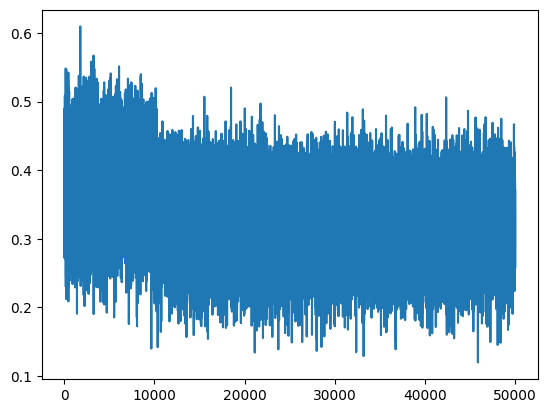

In [1075]:
#--TRAINING--#
import torch.optim


EPOCHS=50000
LR=0.1
BATCH_SIZE=128

optimizer = torch.optim.SGD(parameters, lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.1)


epochs = []
losses = []

for i in range(EPOCHS):
    optimizer.zero_grad()
    
    # select a random batch and use that for fwd + backward for faster iteration
    # batch_indices = torch.randperm(len(Xtr), generator=GEN)
    # batch_indices = batch_indices[:BATCH_SIZE]
    batch_indices = torch.randint(0, Xtr.shape[0], (32,), generator=GEN)

    emb = C[Xtr[batch_indices]] # lookup embeddings corresponding to each row -> (M, BLOCK_SIZE, 2) i.e one 2D vector per char in a row of X

    # view shares the same underlying elements, just rearranges logically
        # (number of examples, number of elems per example)
    emb_view = emb.view((emb.shape[0], BLOCK_SIZE * EMBEDDING_SIZE))
    
    # forward pass: get linear combs + bias for each row, activate with tanh
    h = emb_view @ W
    h = h + bias
    h = h.tanh()
    
    # forward pass 2nd layer to get 27 outputs per row
    probs = h @ W2 + b2
    
    # this is the same as doing probs.softmax, selecting corresponding probabilities with [arange(M), Y], then doing NLL and mean. but better
    nll_loss = F.cross_entropy(probs, Ytr[batch_indices])
    
    epochs.append(i)
    losses.append(nll_loss.log10().item())
    # --Update--#

    nll_loss.backward()

    optimizer.step()
    scheduler.step()

    
    
    # for param in parameters:
    #     param.grad = None
    
    # # backward pass
    # nll_loss.backward()
    
    # # update
    # with torch.no_grad():
    #     for param in parameters:
    #         param -= LR * param.grad
            
print("Loss:", nll_loss.item())

plt.plot(epochs, losses)

## Get loss for dev split

In [1076]:
emb = C[Xdev]
emb_view = emb.view((emb.shape[0], BLOCK_SIZE * EMBEDDING_SIZE))
# forward pass: get linear combs + bias for each row, activate with tanh
h = emb_view @ W
h = h + bias
h = h.tanh()

# forward pass 2nd layer to get 27 outputs per row
probs = h @ W2 + b2

# this is the same as doing probs.softmax, selecting corresponding probabilities with [arange(M), Y], then doing NLL and mean. but better
nll_loss = F.cross_entropy(probs, Ydev)
nll_loss

tensor(2.1825, grad_fn=<NllLossBackward0>)

## Loss for test split

In [1073]:
emb = C[Xtest]
emb_view = emb.view((emb.shape[0], BLOCK_SIZE * EMBEDDING_SIZE))
# forward pass: get linear combs + bias for each row, activate with tanh
h = emb_view @ W
h = h + bias
h = h.tanh()

# forward pass 2nd layer to get 27 outputs per row
probs = h @ W2 + b2

# this is the same as doing probs.softmax, selecting corresponding probabilities with [arange(M), Y], then doing NLL and mean. but better
nll_loss = F.cross_entropy(probs, Ytest)
nll_loss

tensor(2.1842, grad_fn=<NllLossBackward0>)

## Sample from model

In [1111]:
def get_word(max_count=10):
    current_block = [0] * BLOCK_SIZE
    string = []

    for i in range(max_count):
        emb = C[current_block].view(1, BLOCK_SIZE * EMBEDDING_SIZE)
        
        # fwd pass
        h = emb @ W + bias
        h = h.tanh()
    
        probs = h @ W2 + b2
        # turn into probabilities
        probs = probs.softmax(dim=1)
    
        sampled = torch.multinomial(probs, num_samples=1, replacement=True, generator=GEN)
        sampled_idx = sampled.item()
        char = itos[sampled_idx]

        if char == '.':
            break

        string.append(char)

        current_block = current_block[1:] + [sampled_idx]


    return ''.join(string)
    


for i in range(20):
    word = get_word()
    print(word)

sysda
daiyana
iabina
arman
cobreyia
gidriey
hareon
gaygon
gaviland
meka
khia
tery
varo
markio
otya
synoro
bzelana
nikolaiden
sheva
xam


In [1117]:
'gaygon' in names

False